# Implementation of a Neural Composer

In this python notebook, you will be guided towards building neural networks model of symbolic music.

The first part is about processing MIDI files in order to extract a meaningful and normalized dataset. Then you will be asked to implement a first simple model with feedforward artificial neurons, i.e. neurons that does not have any memory of past events. And compare it with a Ngram model.

We will then build and train a recurrent neural network and compare it with the previous results.

Finally and optionally, you can use your trained models to generate new scores.

## How to use this notebook?

Run each cell one after the other. Be sure to understand what is implemented. Be curious and use print() to check the different variable you have interest in or to get a better understanding.

(OPTIONAL) If you struggle with installation/dependencies issues, you can also simply look at the code and suggested set of results and directly answer the questions without actually running the code.

At different steps you will have some design choices, either use the implemented random selection or choose what you want. If your computer goes wild while training your networks, consider using smaller networks with less parameters. Additionaly you are encouraged to modify this code to make it yours. 

Enjoy!

## 0. Imports

Use a kernel with the following libraries installed
- midi (git+https://github.com/vishnubob/python-midi@feature/python3
)
- tensorflow
- h5py
- tqdm
- keras
- pickle

If you have trouble with the installation check
- https://www.tensorflow.org/install/pip
- https://anbasile.github.io/programming/2017/06/25/jupyter-venv/



In [146]:
import midi
import os
import numpy as np
import copy

%matplotlib inline
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = ['#B51F1F', 
     '#00A79F', '#007480', 
     '#413D3A', 
     '#CAC7C7', '#FF0000',
     '#BB7E5D','#FFAE82']
#plt.rcParams['axes.prop_cycle'].by_key()['color'] = c

from cycler import cycler

plt.rc('axes', prop_cycle=(cycler('color', c) +
                           cycler('linestyle', ['-', '--', ':', '-.']*2)))
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

from IPython import display

from tqdm import tqdm

import keras
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Flatten, Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

from collections import *

import pickle

def save(obj, name, path = '../save/'):
    with open(path+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        print(name + ' saved')

def load(name, path = '../load/'):
    with open(path + name + '.pkl', 'rb') as f:
        print(name + ' loaded')
        return pickle.load(f)

## 1. Processing MIDI files

**DESIGN CHOICE** Ordering of chords

In [183]:
chord_order = np.random.choice(['topdown', 'bottomup', 'random'])
print("Simultaneous notes will appear in %s order"%chord_order)

Simultaneous notes will appear in topdown order


In [5]:
def mergeTracks(s, chord_order='bottomup'):
    """
    Merge all tracks in s in a single one where notes 
    are sorted by time and pitch. Pitch ordering can be 
    selected with the chord_order argument.
    """
    singletrack = midi.Track()
    events = []
    for i, track in enumerate(s):
        t = 0
        
        for event in track:
            t += event.tick
            if event.name in ['Note On', 'Note Off']:
                candidate = {'t': t, 'event': event}
                if candidate not in events:
                    events.append(candidate)
    if chord_order == 'bottomup':
        #base to high voice
        events = sorted(events, key=lambda k: (k['t'], k['event'].data[0]))
    elif chord_order == 'topdown':
        #high voice to base
        events = sorted(events, key=lambda k: (k['t'], -k['event'].data[0]))
    elif chord_order == 'random':
        events = sorted(events, key=lambda k: (k['t'], np.random.choice(10)))
    else:
        print('unknown chord ordering')
        
    tick = 0
    for e in events:
        e['event'].tick = e['t'] - tick
        tick = e['t']
        singletrack.append(e['event'])
    return singletrack

def parseMIDI(midi_file_path, chord_order='bottomup'):
    """
    Process the MIDI in midi_file_path to extract
    the sequence of notes (dT, T, P). Timing is in 
    MIDI tick representation. The function also 
    returns the tick per beat (tpb) metaparameter
    """ 
    s = midi.read_midifile(midi_file_path)
    tpb = float(s.resolution)
    events = mergeTracks(s, chord_order=chord_order)
    T = []
    P = [0]
    dT = []
    dP = []
    dt = 0
    for n, event in enumerate(events):
        if event.name == 'Note On' and event.data[1] > 0:
            pitch_n = event.data[0]
            n2 = n
            duration_n = 0
            while True:
                n2 += 1
                if n2 > (len(events)-1):
                    break
                duration_n += events[n2].tick
                if events[n2].data[0] == pitch_n and events[n2].name == 'Note Off':
                    break
                if events[n2].data[0] == pitch_n and events[n2].name == 'Note On' and events[n2].data[1] == 0:
                    break
            if duration_n > 0.:
                dP.append(pitch_n-P[-1])
                P.append(pitch_n)
                T.append(duration_n)
                dT.append(event.tick+dt)
            dt = 0
        elif event.name == 'Note Off' or event.data[1] == 0:
            dt += event.tick
    
    #Tick (integer) to beat fraction (float)
    dT = [float(dt)/tpb for dt in dT]
    T = [float(t)/tpb for t in T]
    P = P[1:]
    dP = dP[1:]
    dP.insert(0,0)
    return dT, T, P, dP, tpb


#Define the path to your data
datapath = "../data/"
#Define which folder
corpus = "ChoralesMusic21"

dataset = {}
for filename in tqdm(os.listdir(datapath+corpus+"/midi/"), desc="Reading MIDI files"):
    if filename[-3:] in ["mid", "MID", "SQU", "KPP", "squ", "kpp"]:
        label = filename[:-4]
        #print(label)
        try:
            dTseq, Tseq, Pseq, dPseq, tpb = parseMIDI(datapath+corpus+"/midi/"+filename, chord_order=chord_order)
        except Exception as e:
            print(e)
            continue
        dataset[label] = {}
        dataset[label]['T']= Tseq
        dataset[label]['dT']= dTseq
        dataset[label]['P']= Pseq
        dataset[label]['dP']= dPseq
        dataset[label]['TPB'] = int(tpb)

Reading MIDI files: 100%|██████████| 358/358 [00:09<00:00, 37.06it/s]


Look at the processed data. The above code extract from MIDI files, the sequence of notes[1:N] where each note[n] is encoded as (dT[n], T[n], P[n], dP[n]) where dT is the timing of each note with respect to the previous (in unit fraction of a quarter note), T is the duration of the note (in unit fraction of a quarter note), P the pitch/key (in integer representation) and dP the interval with respect to the previous note (in integer representation).

In [6]:
sample_label = np.random.choice(list(dataset.keys()))
print(sample_label)
for k,v in dataset[sample_label].items():
    try:
        print(k,len(v),v)
    except:
        print(k,v)

bwv114.7
P 287 [70, 67, 62, 55, 70, 65, 62, 50, 60, 67, 63, 58, 51, 69, 53, 70, 62, 58, 55, 72, 57, 74, 62, 58, 53, 72, 63, 55, 51, 72, 63, 57, 53, 62, 63, 70, 62, 46, 70, 62, 55, 43, 69, 62, 54, 50, 72, 63, 70, 67, 62, 52, 69, 69, 60, 54, 70, 67, 58, 55, 57, 53, 72, 67, 55, 51, 70, 65, 50, 69, 63, 55, 48, 62, 54, 50, 60, 67, 58, 55, 43, 70, 67, 62, 55, 70, 65, 62, 50, 60, 67, 63, 58, 51, 69, 53, 70, 62, 58, 55, 72, 57, 74, 62, 58, 53, 72, 63, 55, 51, 72, 63, 57, 53, 62, 63, 70, 62, 46, 70, 62, 55, 43, 69, 62, 54, 50, 72, 63, 70, 67, 62, 52, 69, 69, 60, 54, 70, 67, 58, 55, 57, 53, 72, 67, 55, 51, 70, 65, 50, 69, 63, 55, 48, 62, 54, 50, 60, 67, 58, 55, 43, 72, 65, 53, 45, 74, 65, 58, 46, 48, 74, 65, 58, 50, 51, 69, 65, 60, 53, 70, 55, 72, 66, 57, 69, 54, 70, 69, 58, 55, 67, 60, 57, 66, 70, 67, 62, 58, 60, 69, 65, 62, 62, 70, 67, 55, 53, 72, 67, 55, 51, 65, 50, 67, 63, 60, 48, 69, 70, 62, 58, 43, 64, 69, 65, 60, 45, 46, 67, 65, 60, 48, 55, 46, 67, 64, 60, 48, 58, 65, 60, 57, 41, 70, 62, 

### 1.1 Rhythm normalization | Find back the score

In [7]:
def findClosest(val, vec, verbose=False, epsilon=1./16.):#allow 64th error
    """
    find the element closest to val in vec 
    """
    vec = [v for v in vec if v not in ["START", "END", "PADD"]]
    diff = [abs(float(el)-float(val)) for el in vec]
    idx = np.argmin(diff)
    if verbose and diff[idx] > 0.:
        print("%f mapped to %f, error: %f"%(val, vec[idx], diff[idx]))
    if diff[idx] > epsilon:
        raise ValueError("%f mapped to %f, error: %f"%(val, vec[idx], diff[idx]))
    
    return vec[idx]

def normalizeRhythm(dataset):
    """
    Fit the rhythm to a finite set of allowed durations
    """
    norm_dataset = copy.deepcopy(dataset)
    bases = [1./8., 1./3.]#32nd and triplet of 8th
    increments = []
    for b in bases:
        m = 0
        while m*b < 1.:
            increments.append(m*b)
            m+=1

    allowed_durations = []
    for d in range(32): #For all durations up to 32 quarter notes
        for i in increments:
            allowed_durations.append(round(d+i, 5))

    increments = sorted(list(set(increments)))
    #print(increments)
    allowed_durations = sorted(list(set(allowed_durations)))
    #print(len(allowed_durations), allowed_durations)

    for label, score in tqdm(dataset.items(), desc="Rhythm normalization"):
        score['dT'][0] = 0.
        norm_dataset[label]['dT'] = [findClosest(dt, allowed_durations) for dt in score['dT']]
        norm_dataset[label]['T'] = [findClosest(t, allowed_durations[1:]) for t in score['T']]

        cumul_dt_err = 0.
        cumul_t_err = 0.
        for dt, t, rounded_dt, rounded_t in zip(score['dT'], score['T'], norm_dataset[label]['dT'], norm_dataset[label]['T']):
            dt_err = abs(dt-rounded_dt)
            t_err = abs(t-rounded_t)
            if dt_err > 0.1:
                print(label, 'dt', dt, rounded_dt)
                #plotPianoroll(score)
                #plt.show()  
            if t_err > 0.1:
                #plotPianoroll(score)
                #plt.show()  
                print(label, 't', t, rounded_t)

            cumul_dt_err += dt_err
            cumul_t_err += t_err
        cumul_dt_err /= len(score['dT'])
        cumul_t_err /= len(score['T'])
        norm_dataset[label]['Err_rounding_dT'] = cumul_dt_err
        norm_dataset[label]['Err_rounding_T'] = cumul_t_err

        #print(label, score['Err_rounding_dT'], score['Err_rounding_T'])
    return norm_dataset, allowed_durations

norm_dataset, duration_set = normalizeRhythm(dataset)



Rhythm normalization: 100%|██████████| 357/357 [00:44<00:00,  8.01it/s]


In [8]:
print(len(duration_set),duration_set)
print([(dt,dtr) for dt, dtr in zip(dataset[sample_label]['dT'], norm_dataset[sample_label]['dT'])])
print([(t,tr) for t, tr in zip(dataset[sample_label]['T'], norm_dataset[sample_label]['T'])])

320 [0.0, 0.125, 0.25, 0.33333, 0.375, 0.5, 0.625, 0.66667, 0.75, 0.875, 1.0, 1.125, 1.25, 1.33333, 1.375, 1.5, 1.625, 1.66667, 1.75, 1.875, 2.0, 2.125, 2.25, 2.33333, 2.375, 2.5, 2.625, 2.66667, 2.75, 2.875, 3.0, 3.125, 3.25, 3.33333, 3.375, 3.5, 3.625, 3.66667, 3.75, 3.875, 4.0, 4.125, 4.25, 4.33333, 4.375, 4.5, 4.625, 4.66667, 4.75, 4.875, 5.0, 5.125, 5.25, 5.33333, 5.375, 5.5, 5.625, 5.66667, 5.75, 5.875, 6.0, 6.125, 6.25, 6.33333, 6.375, 6.5, 6.625, 6.66667, 6.75, 6.875, 7.0, 7.125, 7.25, 7.33333, 7.375, 7.5, 7.625, 7.66667, 7.75, 7.875, 8.0, 8.125, 8.25, 8.33333, 8.375, 8.5, 8.625, 8.66667, 8.75, 8.875, 9.0, 9.125, 9.25, 9.33333, 9.375, 9.5, 9.625, 9.66667, 9.75, 9.875, 10.0, 10.125, 10.25, 10.33333, 10.375, 10.5, 10.625, 10.66667, 10.75, 10.875, 11.0, 11.125, 11.25, 11.33333, 11.375, 11.5, 11.625, 11.66667, 11.75, 11.875, 12.0, 12.125, 12.25, 12.33333, 12.375, 12.5, 12.625, 12.66667, 12.75, 12.875, 13.0, 13.125, 13.25, 13.33333, 13.375, 13.5, 13.625, 13.66667, 13.75, 13.875, 14.

**Question:** What did the above normalization procedure did to the original data? 

**Answer:**

**Question:** What would be the effect on a dataset with live MIDI recordings?

**Answer:**

Computing dT dictionary: 100%|██████████| 357/357 [00:00<00:00, 23400.74it/s]


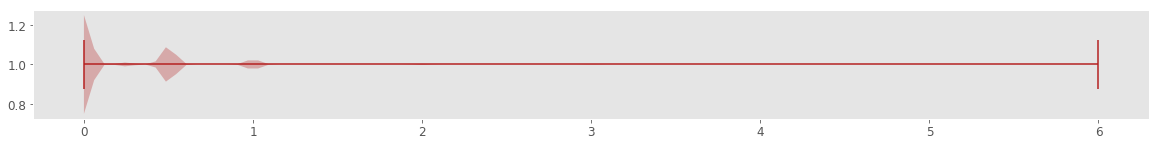

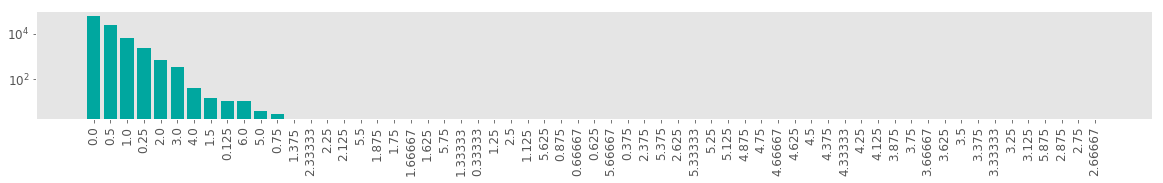

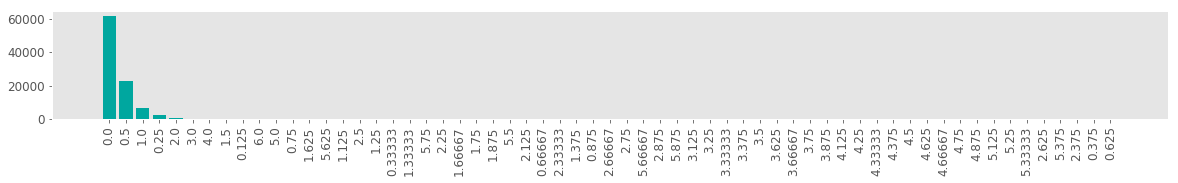

Computing T dictionary: 100%|██████████| 357/357 [00:00<00:00, 19748.97it/s]


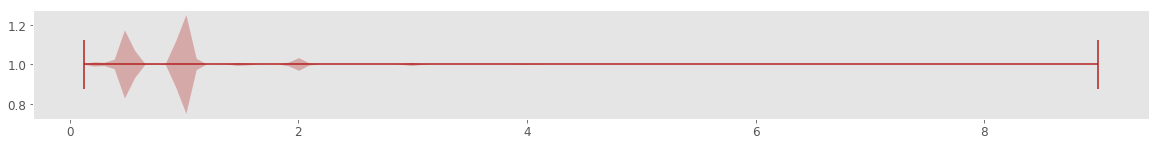

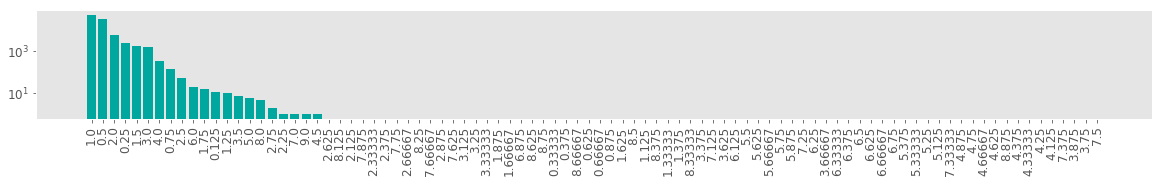

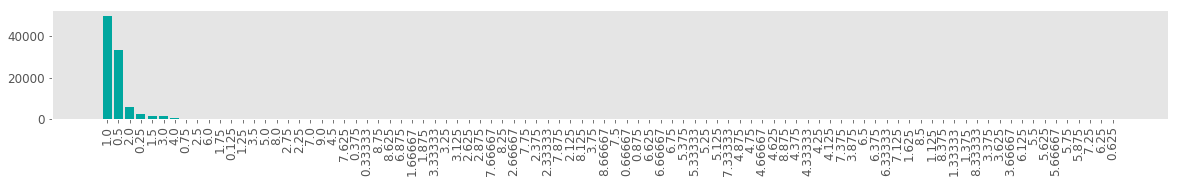

Computing P dictionary: 100%|██████████| 357/357 [00:00<00:00, 27764.49it/s]


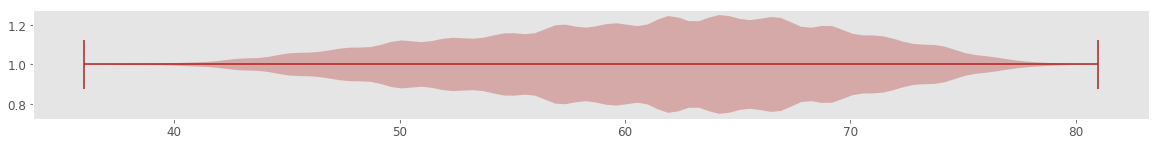

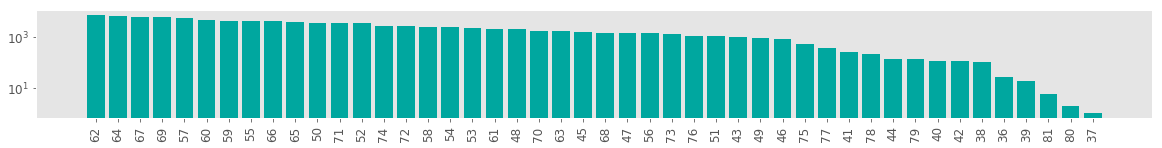

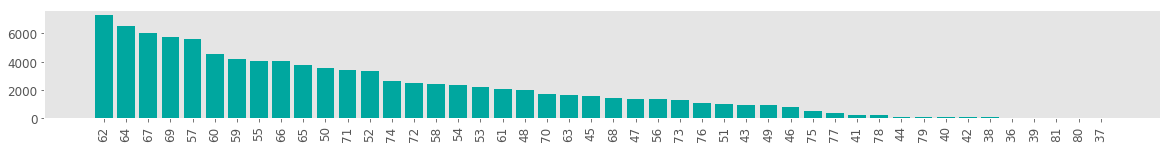

Computing dP dictionary: 100%|██████████| 357/357 [00:00<00:00, 26163.56it/s]


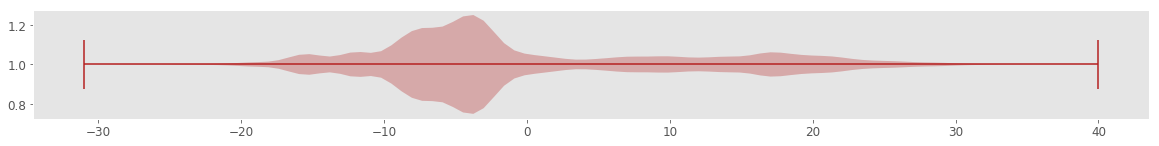

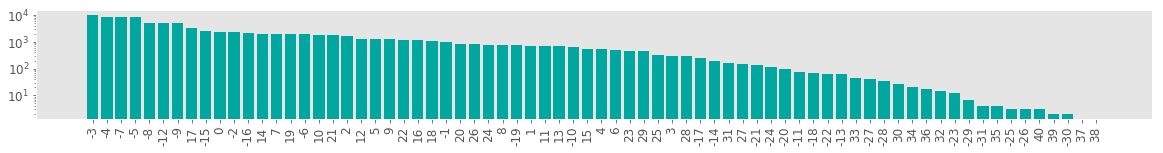

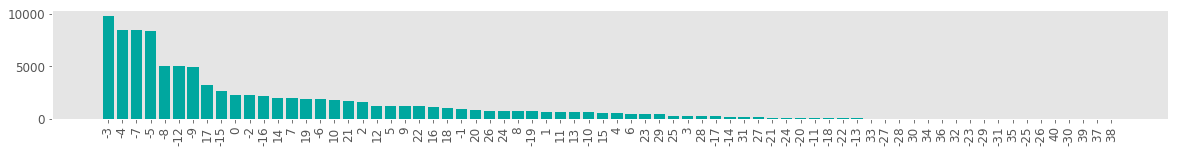

In [9]:
def getDictionaries(dataset, plot = False):
    """
    Computes the finite set of values needed to formalize an entire dataset
    """
    dictionaries = {}
    for key in ['dT', 'T', 'P', 'dP']:
        flatten = []
        for label, score in tqdm(dataset.items(), desc="Computing %s dictionary"%key):
            for x in score[key]:
                flatten.append(x)
                
        if 'P' in key:
            dictionaries[key] = list(range(min(flatten), max(flatten)+1))
        elif 'dT' in key:
            dictionaries[key] = duration_set[:duration_set.index(max(flatten))+1]
        elif 'T' in key:
            dictionaries[key] = duration_set[1:duration_set.index(max(flatten))+1]
        elif 'dP' in key:
            dictionaries[key] = list(range(min(flatten), max(flatten)+1))
        else:
            dictionaries[key] = sorted(list(set(flatten)))
    
        if plot:
            x = np.asarray(dictionaries[key])
            y = np.asarray([flatten.count(entry) for entry in x])
            dictionaries[key+'_distr'] = y
            
            plt.figure(figsize=(20,2))
            plt.violinplot(flatten, vert=False)

            #plt.xlim([0,1000])

            plt.figure(figsize=(20,2))
            sorted_idxes = np.argsort(y)[::-1]
            y = y[sorted_idxes]
            x = x[sorted_idxes]
            plt.bar(range(len(y)), y, color=c[1])
            plt.xticks(range(len(y)), x, rotation=90)
            #plt.xlim([0,1000])
            plt.yscale('log')
            #plt.savefig('../'+key+"_distr.png")
            plt.show()
            
            plt.figure(figsize=(20,2))
            sorted_idxes = np.argsort(y)[::-1]
            y = y[sorted_idxes]
            x = x[sorted_idxes]
            plt.bar(range(len(y)), y, color=c[1])
            plt.xticks(range(len(y)), x, rotation=90)
            #plt.xlim([0,1000])
           # plt.yscale('log')
            #plt.savefig('../'+key+"_distr.png")
            plt.show()
    return dictionaries

dictionaries = getDictionaries(norm_dataset, plot=True)


In [12]:
for k,v in dictionaries.items():
    if k in ['dT', 'T', 'P', 'dP']:
        print(k, len(v), v)


dP 72 [-31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
T 90 [0.125, 0.25, 0.33333, 0.375, 0.5, 0.625, 0.66667, 0.75, 0.875, 1.0, 1.125, 1.25, 1.33333, 1.375, 1.5, 1.625, 1.66667, 1.75, 1.875, 2.0, 2.125, 2.25, 2.33333, 2.375, 2.5, 2.625, 2.66667, 2.75, 2.875, 3.0, 3.125, 3.25, 3.33333, 3.375, 3.5, 3.625, 3.66667, 3.75, 3.875, 4.0, 4.125, 4.25, 4.33333, 4.375, 4.5, 4.625, 4.66667, 4.75, 4.875, 5.0, 5.125, 5.25, 5.33333, 5.375, 5.5, 5.625, 5.66667, 5.75, 5.875, 6.0, 6.125, 6.25, 6.33333, 6.375, 6.5, 6.625, 6.66667, 6.75, 6.875, 7.0, 7.125, 7.25, 7.33333, 7.375, 7.5, 7.625, 7.66667, 7.75, 7.875, 8.0, 8.125, 8.25, 8.33333, 8.375, 8.5, 8.625, 8.66667, 8.75, 8.875, 9.0]
P 46 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 5

**Question**: What does the different dictionaries represent?

**Answer:**

0.0 1.0 70
0.0 1.0 67
0.0 1.0 62
0.0 1.0 55
1.0 1.0 70
0.0 1.0 65
0.0 0.5 62
0.0 1.0 50
0.5 0.5 60
0.5 0.5 67
0.0 1.0 63
0.0 1.0 58
0.0 0.5 51
0.5 0.5 69
0.0 0.5 53
0.5 0.5 70
0.0 1.0 62
0.0 1.0 58
0.0 0.5 55
0.5 0.5 72
0.0 0.5 57
0.5 1.0 74
0.0 1.0 62
0.0 1.0 58
0.0 1.0 53
1.0 1.0 72
0.0 1.0 63
0.0 1.0 55
0.0 1.0 51
1.0 1.0 72
0.0 0.25 63
0.0 1.0 57
0.0 1.0 53
0.25 0.25 62
0.25 0.5 63
0.5 1.0 70
0.0 1.0 62
0.0 1.0 46
1.0 1.0 70
0.0 1.0 62
0.0 1.0 55
0.0 1.0 43
1.0 1.0 69
0.0 0.5 62
0.0 0.5 54
0.0 1.0 50
0.5 0.5 72
0.0 0.5 63
0.5 0.5 70
0.0 0.5 67
0.0 0.5 62
0.0 0.5 52
0.5 0.5 69
0.0 0.5 69
0.0 0.5 60
0.0 0.5 54
0.5 1.0 70
0.0 1.0 67
0.0 0.5 58
0.0 0.5 55
0.5 0.5 57
0.0 0.5 53
0.5 0.5 72
0.0 0.5 67
0.0 1.0 55
0.0 0.5 51
0.5 0.5 70
0.0 0.5 65
0.0 0.5 50
0.5 2.0 69
0.0 1.0 63
0.0 1.0 55
0.0 1.0 48
1.0 0.5 62
0.0 1.0 54
0.0 1.0 50
0.5 0.5 60
0.5 1.0 67
0.0 1.0 58
0.0 1.0 55
0.0 1.0 43
1.0 1.0 70
0.0 1.0 67
0.0 1.0 62
0.0 1.0 55
1.0 1.0 70
0.0 1.0 65
0.0 0.5 62
0.0 1.0 50
0.5 0.5 60
0.5 0.

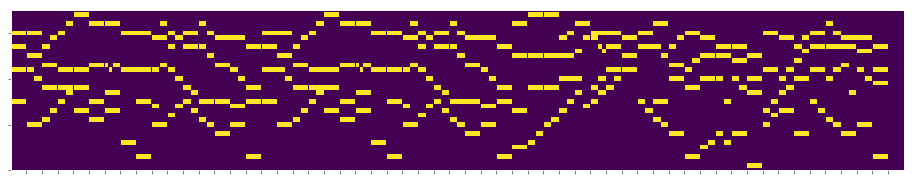

In [13]:
def plotPianoroll(score, verbose=False):
    """
    Plot a score in the pianoroll representation
    """
   
    resolution = 128#ticks per beat
    L = np.sum(score['dT'])+2.#beat
    pianoroll = np.zeros((int(resolution*L),127))
    tick = 0.
    for dt, t, p in zip(score['dT'], score['T'], score['P']):
        tick += dt
        tick_int = int(np.ceil(resolution*tick))
        pianoroll[tick_int:tick_int+int(np.ceil(t*resolution))-5,p] = 1
        if verbose:
            print(dt,t,p)
    
    plt.figure(figsize=(16,10))
    ax1 = plt.subplot(311)
    ax1.imshow(pianoroll.T, origin='lower', aspect='auto')
    ax1.set_xticks(np.arange(resolution, int(L*resolution), int(resolution)))
    # Labels for major ticks
    ax1.set_xticklabels([]);
    ax1.set_ylim([min(score['P'])-1,max(score['P'])+1])
    ax1.set_yticklabels([])
    
plotPianoroll(norm_dataset[sample_label], verbose=True)
    

Save your data if you want to skip this step the next time you open this notebook

In [21]:
#Save the data in the ../save directory
save(dictionaries, corpus+'_dictionaries')
save(norm_dataset,  corpus+'_dataset')

ChoralesMusic21_dictionaries saved
ChoralesMusic21_dataset saved


Load the data if the correct files are in the ../load directory. Run this instead of section 1 if you reopen the notebook.

In [86]:
#Load the data from the ../load directory
dictionaries = load(corpus+'_dictionaries')
norm_dataset = load(corpus+'_dataset')

ChoralesMusic21_dictionaries loaded
ChoralesMusic21_dataset loaded


## 2. Predict next note from fixed-size history

We will implement first a baseline N-gram model which goal is to approximate
$$Pr(P[n+1]|P[n-N:n])$$

Then we will use the ability of neural networks to easily handled multiple inputs to add more information to the pitch transition model that will approximate
$$Pr(P[n+1]|P[n-N:n], dT[n-N:n], T[n-N:n])$$

### 2.1 Build, train and compute the performance of a N-gram model

In [15]:
#Split the data in training and validation set
all_labels = list(norm_dataset.keys())
np.random.shuffle(all_labels)
validation_split = int(0.9*len(all_labels))
labels = {'train': all_labels[:validation_split], 'valid': all_labels[validation_split:]}

In [185]:
def train_Ngram(N = np.random.choice(range(1,5))):
    
    def normalize(counter):
        s = float(sum(counter.values()))
        for c,cnt in counter.items():
            counter[c] = round(cnt/s,4)
        return counter
    
    models = []
    for N in range(N+1):
        counter_table = defaultdict(Counter)
        for label in tqdm(labels['train'], desc="Training %i-gram model"%N):
            score = norm_dataset[label]
            for n in range(N,len(score['P'])):
                history = score['P'][n-N:n]
                p = score['P'][n]
                history_tag = "-".join([str(h) for h in history])
                counter_table[history_tag][str(p)]+=1

        probability_table = {hist:normalize(p) for hist, p in counter_table.items()} 
        models.append({'order': N, 'prob_table': probability_table})
    return models

#Train an Ngram model with fallback
maxN = 10
ngram_models = train_Ngram(N=maxN)



Training 10-gram model: 100%|██████████| 321/321 [00:00<00:00, 339.46it/s]


In [186]:
def performance(score, N):
    """
    Compute the performance (prediction accuracy and negative log-likelihood) of the Ngram model.
    """
    pr_pnp1 = []
    acc = []
    for n in range(len(score['P'])):
        p = str(score['P'][n])
        if n-N < 0:
            history = score['P'][:n]
            order = len(history)
            #print(history, p)
        else:
            history = score['P'][n-N:n]
            order = N
        history_tag = "-".join([str(h) for h in history])
        while history_tag not in ngram_models[order]['prob_table'].keys():
            order -= 1
            history_tag = "-".join([str(h) for h in score['P'][n-order:n]])
            
        pr_pnp1.append(ngram_models[order]['prob_table'][history_tag][p])
        try:
            if ngram_models[order]['prob_table'][history_tag][p] == max(ngram_models[order]['prob_table'][history_tag].values()):
                acc.append(1)
            else:
                acc.append(0)
        except:
            print(history_tag, p)
            print(ngram_models[order]['prob_table'][history_tag])
            print(ngram_models[order]['prob_table'][history_tag].values())
            raise
    return np.mean(acc), -np.mean([np.log(p) for p in pr_pnp1])


all_accs = []
all_nlls = []

for N in range(maxN):
    all_accs.append({'order': N})
    all_nlls.append({'order': N})
    for split in ['train', 'valid']:
        accs = []
        nlls = []
        for label in tqdm(labels[split], desc="Computing %i_gram model performance on %s dataset performances"%(N, split)):
            score = norm_dataset[label]
            acc, nll = performance(score, N)
            accs.append(acc)
            nlls.append(nll)
        all_accs[-1][split] = np.mean(accs)
        all_nlls[-1][split] = np.mean(nlls)


Computing 0_gram model performance on train dataset performances:   8%|▊         | 26/321 [00:00<00:01, 248.10it/s]/Users/Flo/Documents/PhD/Code/NIPS18/src/nipsenv/lib/python3.4/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log
Computing 0_gram model performance on train dataset performances: 100%|██████████| 321/321 [00:01<00:00, 171.92it/s]
Computing 0_gram model performance on valid dataset performances: 100%|██████████| 36/36 [00:00<00:00, 197.08it/s]
Computing 1_gram model performance on train dataset performances: 100%|██████████| 321/321 [00:02<00:00, 144.59it/s]
Computing 1_gram model performance on valid dataset performances: 100%|██████████| 36/36 [00:00<00:00, 200.25it/s]
Computing 2_gram model performance on train dataset performances: 100%|██████████| 321/321 [00:02<00:00, 141.77it/s]
Computing 2_gram model performance on valid dataset performances: 100%|██████████| 36/36 [00:00<00:00, 176.81it/s]
Computing 3_gram model performance o

0.46908107468305005


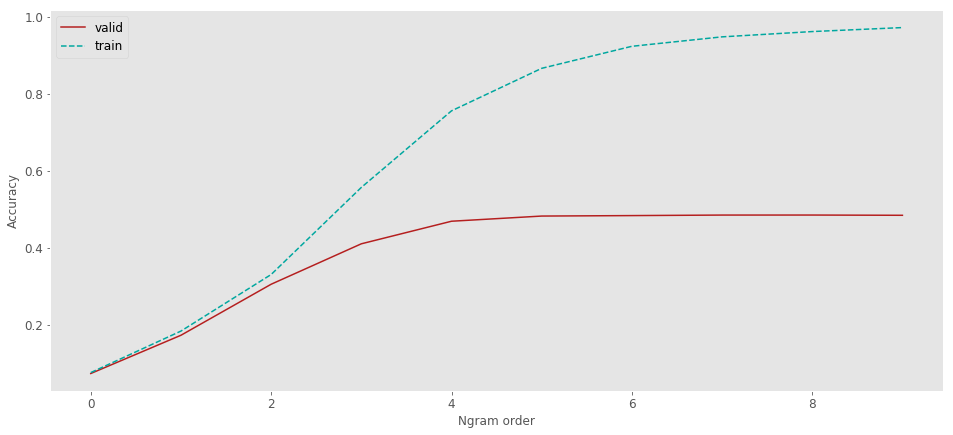

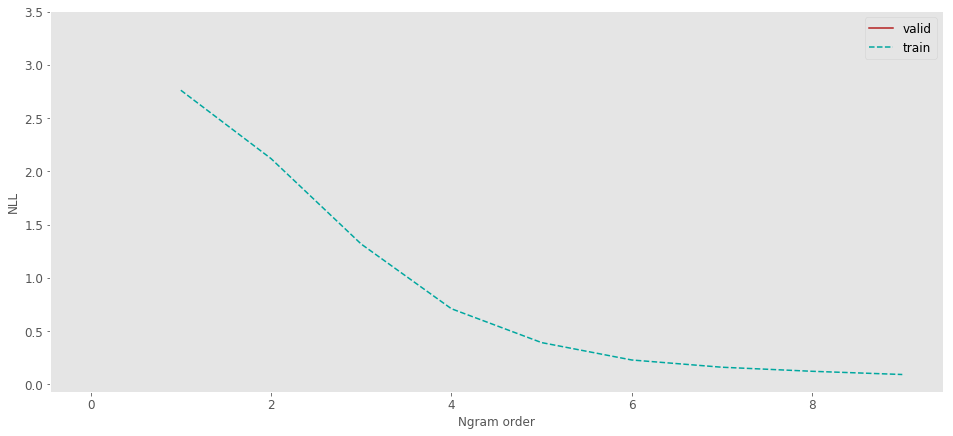

In [187]:
plt.figure(figsize=(16,7))
plt.plot(range(maxN), [all_accs[N]['valid'] for N in range(maxN)], label='valid', c=c[0])
plt.plot(range(maxN), [all_accs[N]['train'] for N in range(maxN)], label='train', c=c[1])
plt.xlabel('Ngram order')
plt.ylabel('Accuracy')
print(all_accs[4]['valid'])
plt.legend(loc='best')

plt.figure(figsize=(16,7))
plt.plot(range(maxN), [all_nlls[N]['valid'] for N in range(maxN)], label='valid', c=c[0])
plt.plot(range(maxN), [all_nlls[N]['train'] for N in range(maxN)], label='train', c=c[1])
plt.xlabel('Ngram order')
plt.ylabel('NLL')
plt.legend(loc='best')

**Question**: Comment on the difference between training and validation set performances

**Answer:**

**Question:** What is the best order N (history size) to model $$Pr(P[n+1]|P[n-N:n])? Why?

**Answer:**

**Question:** What is the problem in computing the validation set NLL? 

**Answer:**

### 2.2 Build, train and compute performances of feedforward neural networks model of pitch transition

In [ ]:
#Only run this once before training your first model. It will collect the learning curves of all your models
logs = dict()

**DESIGN CHOICE** History (N) size, layer numbers, layer sizes and activation functions

In [189]:
#DESIGN CHOICES: 
#LAYER NUMBER
net_depth = np.random.choice(range(1,5))
#LAYER SIZE
layer_size = np.random.choice([64, 128, 256, 512])
#ACTIVATION FUNCTIONS (https://keras.io/activations/)
activation = np.random.choice(['sigmoid', 'tanh', 'relu', 'selu', 'linear'])
#HISTORY SIZE
N = np.random.choice(range(1,maxN))
#(OPTIONAL) REGULARIZATION
#...
print("Building a feedforward model of upcoming pitch predictions given the last %i notes with %i layers composed of %i %s units"%(N, net_depth, layer_size, activation))

model_label = '%ix%i_%s_N=%i'%(net_depth,layer_size,activation, N)

Building a feedforward model of upcoming pitch predictions given the last 8 notes with 4 layers composed of 128 sigmoid units


In [64]:
#Tokenize data to map each note[n]=(dT[n], T[n], P[n]) to a unique set of three active input neurons
dT = []
T = []
P = []
for label, score in tqdm(norm_dataset.items(), desc='Computing I/O tensors'):
    dT.append(np_utils.to_categorical([dictionaries['dT'].index(dt) for dt in score['dT']], len(dictionaries['dT'])))
    T.append(np_utils.to_categorical([dictionaries['T'].index(t) for t in score['T']], len(dictionaries['T'])))
    P.append(np_utils.to_categorical([dictionaries['P'].index(p) for p in score['P']], len(dictionaries['P'])))

XdT = []
XT = []
XP = []
YP = []
for dt, t, p in zip(dT, T, P):
    for n in range(N,len(dt)):
        XdT.append(dt[n-N:n].flatten())
        XT.append(t[n-N:n].flatten())
        XP.append(p[n-N:n].flatten())
        YP.append(p[n])
XdT = np.asarray(XdT, dtype=int)
XT = np.asarray(XT, dtype=int)
XP = np.asarray(XP, dtype=int)
YP = np.asarray(YP, dtype=int)
print(XdT.shape, XT.shape, XP.shape, YP.shape)

Computing I/O tensors: 100%|██████████| 357/357 [00:00<00:00, 1290.50it/s]


(93909, 244) (93909, 360) (93909, 184) (93909, 46)


In [138]:
#Constructing computation graph
X = dict()
H = dict()
Y = dict()

X['dT'] = Input(shape=(len(dictionaries['dT'])*N,), name='XdT')
X['T'] = Input(shape=(len(dictionaries['T'])*N,), name='XT')
X['P'] = Input(shape=(len(dictionaries['P'])*N,), name='XP')

H['P'] = Concatenate(name='concatenate_inputs', trainable=False)([X['dT'], X['T'], X['P']])

for l in range(net_depth):
    H['P'] = Dense(layer_size, activation=activation)(H['P'])
Y['P'] = Dense(len(dictionaries['P']), activation='softmax', name='YP')(H['P'])

model = Model(inputs = [X['dT'], X['T'], X['P']], outputs = [Y['P']])
model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(lr=1e-3),
    metrics=['acc'])
model.summary()

#Training model
filepath = '../save/'+model_label+'.save'
checkpoint =  ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.01, patience=10)
callbacks_list = [checkpoint, early_stopping]
log = model.fit({'XdT': XdT, 'XT': XT, 'XP': XP}, {'YP': YP}, 
                                    epochs=100, 
                                    validation_split=0.1, 
                                    batch_size=64,
                                    callbacks=callbacks_list)
logs[model_label] = log.history


Building a feedforward model of upcoming pitch predictions given the last 4 notes with 3 layers composed of 128 selu units
(93909, 244) (93909, 360) (93909, 184) (93909, 46)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XdT (InputLayer)                (None, 244)          0                                            
__________________________________________________________________________________________________
XT (InputLayer)                 (None, 360)          0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 184)          0                                            
__________________________________________________________________________________________________
concatenate_inputs (Concatenate (N

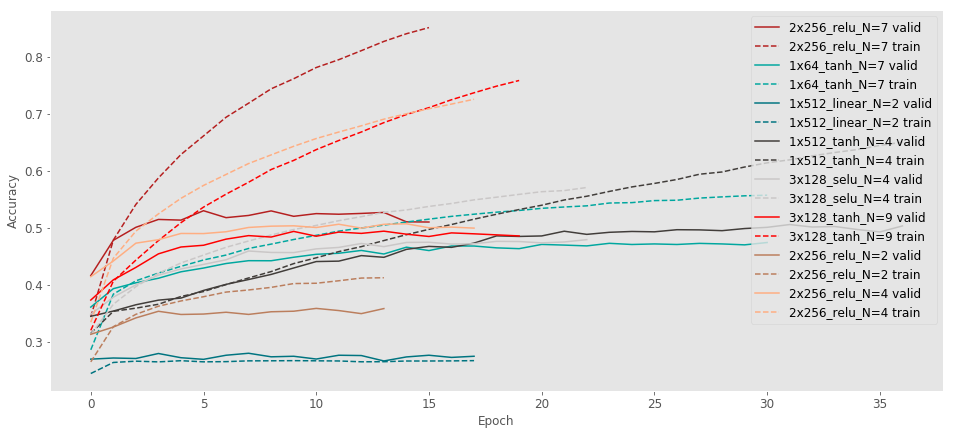

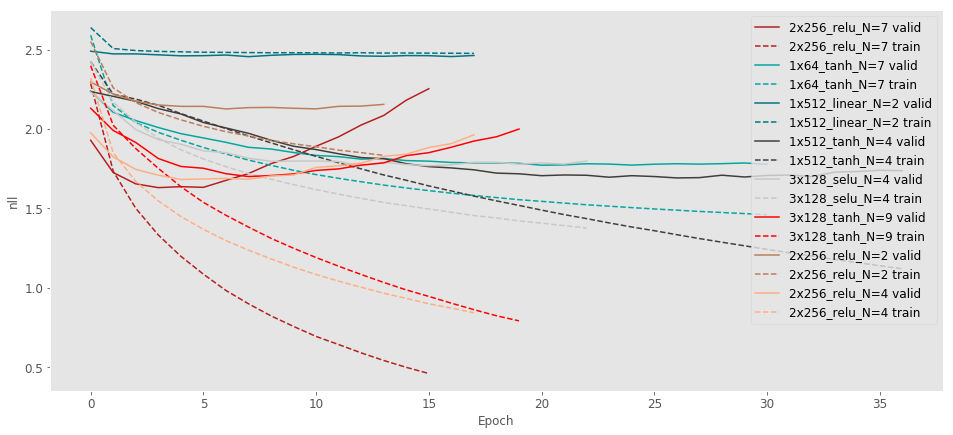

In [141]:
plt.figure(figsize=(16,7))
cidx = 0
for model_label, log in logs.items():
    
    plt.plot(log['val_acc'], '-', label=model_label+' valid', c=c[cidx])
    plt.plot(log['acc'], '--', label=model_label+' train', c=c[cidx])
    plt.legend(loc='best')
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    cidx+=1
plt.figure(figsize=(16,7))
cidx = 0
for model_label, log in logs.items():
    
    plt.plot(log['val_loss'], '-', label=model_label+' valid', c=c[cidx])
    plt.plot(log['loss'], '--', label=model_label+' train', c=c[cidx])
    plt.legend(loc='best')
    plt.ylabel("nll")
    plt.xlabel("Epoch")
    cidx+=1
    

Depending on your interest, vary either the length of the history (as for Ngram) or keep N fixed and try different architectures (or both). Report your results on a single plot with both N-gram and your artificial networks final accuracies (train and valid). To do that, simply rerun the code from section 2.2 with different parameters.

In [142]:
accuracies = dict()
accuracies['Ngram'] = {'train': [(M, all_accs[M]['train']) for M in range(maxN)],
                       'valid': [(M, all_accs[M]['valid']) for M in range(maxN)]}
for model_label, log in logs.items():
    M = int(model_label[-1])
    model_label = model_label[:-4]
    if model_label not in list(accuracies.keys()):
        accuracies[model_label] = {'train': [(M,max(log['acc']))],
                              'valid': [(M,max(log['val_acc']))]}
    else:
        accuracies[model_label]['train'].append((M,max(log['acc'])))
        accuracies[model_label]['valid'].append((M,max(log['val_acc'])))
print(accuracies)

{'3x128_tanh': {'train': [(9, 0.7581744279932018)], 'valid': [(9, 0.4937588191117809)]}, '1x512_linear': {'train': [(2, 0.2665453264499394)], 'valid': [(2, 0.27950966922706244)]}, '2x256_relu': {'train': [(7, 0.8510065346989781), (2, 0.41200093940817284), (4, 0.7252182966998372)], 'valid': [(7, 0.5296208530805687), (2, 0.3582373455136898), (4, 0.5066553082675322)]}, 'Ngram': {'train': [(0, 0.07572845727224514), (1, 0.18360729421113287), (2, 0.33062907138151404), (3, 0.5569514897468104), (4, 0.7559872437725966), (5, 0.8664736112904523), (6, 0.9237320015217237), (7, 0.9482758885549362), (8, 0.9620226932994196), (9, 0.9723900601207339)], 'valid': [(0, 0.07332772537017317), (1, 0.17274811157329328), (2, 0.3053198815100378), (3, 0.410422405926559), (4, 0.46908107468305005), (5, 0.4825276260978543), (6, 0.4837482767349981), (7, 0.485108758480387), (8, 0.48516330692455), (9, 0.4845256955403728)]}, '3x128_selu': {'train': [(4, 0.5703873730926705)], 'valid': [(4, 0.47886274086821007)]}, '1x512_

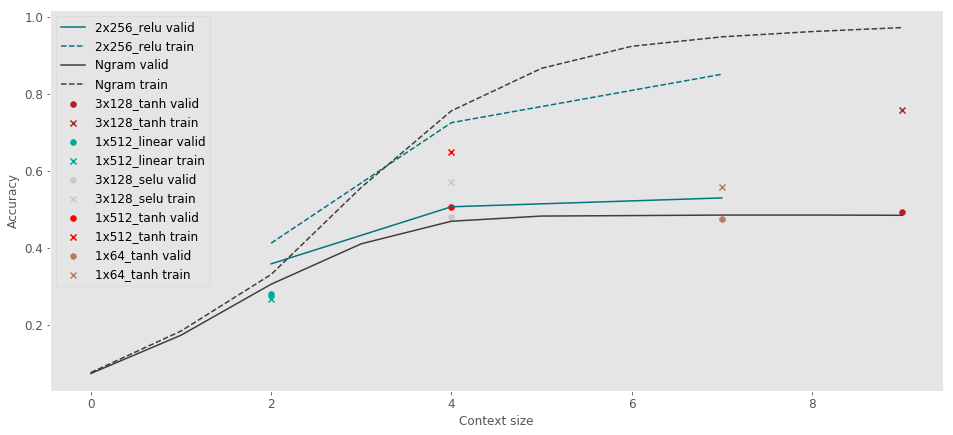

In [145]:
plt.figure(figsize=(16,7))
cidx = 0
for model_label, acc in accuracies.items():
    x = np.asarray([v[0] for v in acc['valid']])
    y = np.asarray([v[1] for v in acc['valid']])
    idxes = np.argsort(x)
    x = x[idxes]
    y = y[idxes]
    if len(x) > 1: 
        plt.plot(x,y,'-',label=model_label+' valid', c=c[cidx])
    else:
        plt.scatter(x[0],y[0],label=model_label+' valid', c=c[cidx])
        
    x = np.asarray([v[0] for v in acc['train']])
    y = np.asarray([v[1] for v in acc['train']])
    idxes = np.argsort(x)
    x = x[idxes]
    y = y[idxes]
    if len(x) > 1: 
        plt.plot(x,y,'--',label=model_label+' train', c=c[cidx])
    else:
        plt.scatter(x[0],y[0],marker='x',label=model_label+' train', c=c[cidx])
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.ylabel('Accuracy')
    plt.xlabel('Context size')
    cidx+=1





**Question:** Comment on your results. How does it compares with the Ngram model in term of performances and generalization?

**Answer:**

**Question:** What is yout best performing model? Why?

**Answer:**

In [174]:
#write the label of your best performing model here
best_ffmodel = '2x256_relu'

## 3 Build, train and compute performances of a recurrent neural network model of pitch prediction

As it is well known in linguistic, fixed sized memory cannot perform well on text data. It is the same for music. You will now be constructing a recurrent neural network (RNN) model of pitch transition that approximate

$$Pr(P[n+1]|dT[:n],T[:n],P[:n])$$

Thanks to the recurrent connections, such a model can have an internal representation of the full history of notes. It is through training that this representation will be optimized in order to have better predictive performances

In [ ]:
#Only run this once before training your first recurrent model. It will collect the learning curves of all your models
recurrent_logs = dict()

**DESIGN CHOICES** Layer number, layer size and activation function

In [190]:
#DESIGN CHOICES: 
#LAYER NUMBER
net_depth = np.random.choice(range(1,4))
#LAYER SIZE
layer_size = np.random.choice([64, 128, 256, 512])
#ACTIVATION FUNCTIONS (https://keras.io/activations/)
activation = np.random.choice(['GRU', 'LSTM', 'RNN'])
#(OPTIONAL) REGULARIZATION
#...
print("Building a recurrent model of upcoming pitch predictions with %i layers composed of %i %s units"%(net_depth, layer_size, str(activation)))

model_label = '%ix%i_%s'%(net_depth,layer_size,str(activation))

#Map the activation function string to the corresponding keras recurrent unit
if activation == 'GRU':
    activation = GRU
elif activation == 'LSTM':
    activation = LSTM
elif activation == 'RNN':
    activation = SimpleRNN
else:
    print('unknown activation')

Building a recurrent model of upcoming pitch predictions with 2 layers composed of 512 RNN units


In [203]:
#Compute the I/O tensors
all_lengths = [len(x) for x in dT]
L = int(np.mean(all_lengths) + 2*np.std(all_lengths))
XdT = pad_sequences(dT, value=0, dtype="int32", padding="post", truncating="post", maxlen=L+1)
XT = pad_sequences(T, value=0, dtype="int32", padding="post", truncating="post", maxlen=L+1)
XP = pad_sequences(P, value=0, dtype="int32", padding="post", truncating="post", maxlen=L+1)

print(XdT.shape, XT.shape, XP.shape)

(357, 526, 61) (357, 526, 90) (357, 526, 46)


In [177]:
#Construct the model computation graph
X = dict()
M = dict()
H = dict()
Y = dict()

X['dT'] = Input(shape=(L,len(dictionaries['dT'])), name='XdT')
X['T'] = Input(shape=(L,len(dictionaries['T'])), name='XT')
X['P'] = Input(shape=(L,len(dictionaries['P'])), name='XP')
                
M['dT'] = Masking(mask_value=0., name='dT_mask', trainable=False)(X['dT'])
M['T'] = Masking(mask_value=0., name='T_mask', trainable=False)(X['T'])
M['P'] = Masking(mask_value=0., name='P_mask', trainable=False)(X['P'])
                
H['P'] = Concatenate(name='concatenate_inputs', trainable=False)([M['dT'], M['T'], M['P']])

for l in range(net_depth):
    H['P'] = activation(int(layer_size), return_sequences=True, stateful=False)(H['P'])
Y['P'] = TimeDistributed(Dense(len(dictionaries['P']), activation='softmax'), name='YP')(H['P'])

model = Model(inputs = [X['dT'], X['T'], X['P']], outputs = [Y['P']])
model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(lr=1e-3),
    metrics=['acc'])
model.summary()

#Train the model
filepath = '../save/'+model_label+'.save'
checkpoint =  ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.01, patience=10)
callbacks_list = [checkpoint, early_stopping]
log = model.fit({'XdT': XdT[:,:-1], 'XT': XT[:,:-1], 'XP': XP[:,:-1]}, {'YP': XP[:,1:]}, 
                                    epochs=200, 
                                    validation_split=0.1, 
                                    batch_size=32,
                                    callbacks=callbacks_list)
recurrent_logs[model_label] = log.history



Building a recurrent model of upcoming pitch predictions with 2 layers composed of 256 GRU units
(357, 526, 61) (357, 526, 90) (357, 526, 46)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XdT (InputLayer)                (None, 525, 61)      0                                            
__________________________________________________________________________________________________
XT (InputLayer)                 (None, 525, 90)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 525, 46)      0                                            
__________________________________________________________________________________________________
dT_mask (Masking)               (None, 525, 61)      0           X

321/321 [==============================] - 36s 112ms/step - loss: 1.4916 - acc: 0.5438 - val_loss: 1.5849 - val_acc: 0.5141
Epoch 41/200
321/321 [==============================] - 32s 100ms/step - loss: 1.4798 - acc: 0.5469 - val_loss: 1.5786 - val_acc: 0.5088
Epoch 42/200
321/321 [==============================] - 31s 97ms/step - loss: 1.4549 - acc: 0.5554 - val_loss: 1.5634 - val_acc: 0.5109
Epoch 43/200
321/321 [==============================] - 31s 97ms/step - loss: 1.4337 - acc: 0.5599 - val_loss: 1.5497 - val_acc: 0.5146
Epoch 44/200
321/321 [==============================] - 36s 112ms/step - loss: 1.4149 - acc: 0.5664 - val_loss: 1.5372 - val_acc: 0.5227
Epoch 45/200
321/321 [==============================] - 39s 121ms/step - loss: 1.4050 - acc: 0.5678 - val_loss: 1.5238 - val_acc: 0.5238
Epoch 46/200
321/321 [==============================] - 35s 108ms/step - loss: 1.3840 - acc: 0.5716 - val_loss: 1.5121 - val_acc: 0.5285
Epoch 47/200
321/321 [==============================] - 

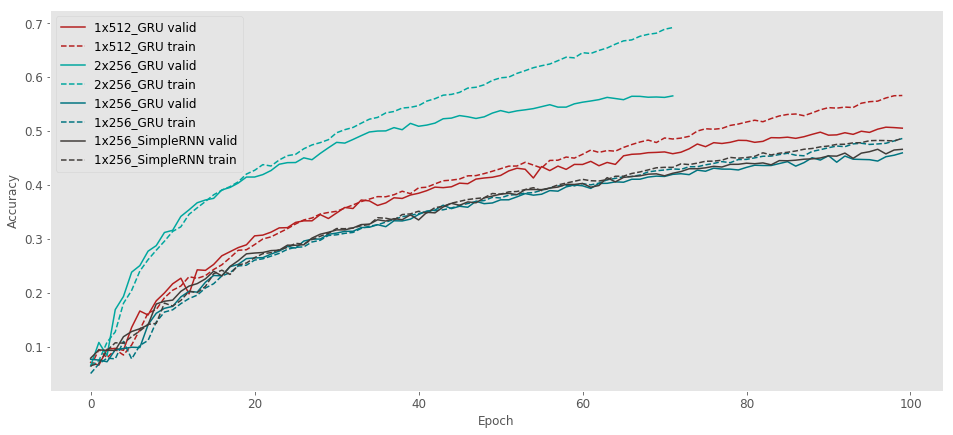

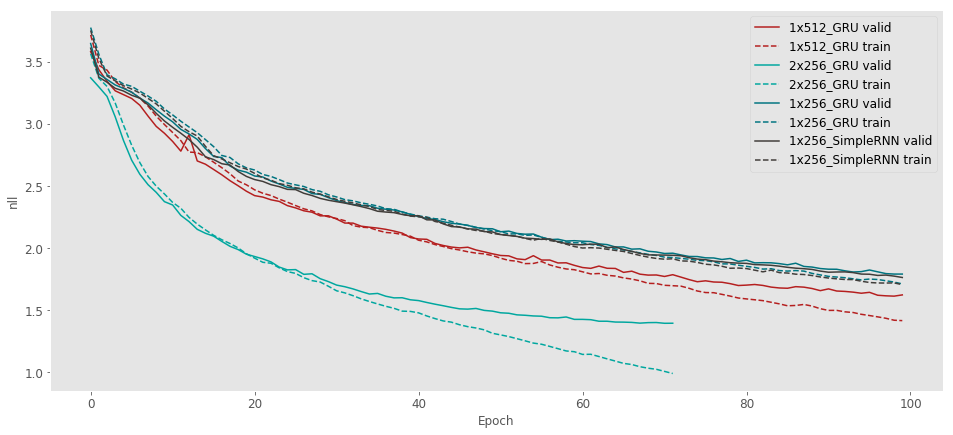

In [179]:
plt.figure(figsize=(16,7))
cidx = 0
for model_label, log in recurrent_logs.items():
    
    plt.plot(log['val_acc'], '-', label=model_label+' valid', c=c[cidx])
    plt.plot(log['acc'], '--', label=model_label+' train', c=c[cidx])
    plt.legend(loc='best')
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    cidx+=1
plt.figure(figsize=(16,7))
cidx = 0
for model_label, log in recurrent_logs.items():
    
    plt.plot(log['val_loss'], '-', label=model_label+' valid', c=c[cidx])
    plt.plot(log['loss'], '--', label=model_label+' train', c=c[cidx])
    plt.legend(loc='best')
    plt.ylabel("nll")
    plt.xlabel("Epoch")
    cidx+=1
    

**Question** After training different model architecture, comment on the learning curves in terms of generalization (gap), training speed and convergence

**Answer:**

**Question:** What is your best recurrent model architecture? Why?

**Answer:**

In [200]:
#write the label of your best recurrent model
best_recurrentmodel = "2x256_GRU"

In [201]:
#Compare with Ngram and best_ffmodel

accuracies = dict()
accuracies['Ngram'] = {'train': [(M, all_accs[M]['train']) for M in range(maxN)],
                       'valid': [(M, all_accs[M]['valid']) for M in range(maxN)]}

for model_label, log in logs.items():
    M = int(model_label[-1])
    model_label = model_label[:-4]
    if model_label == best_ffmodel:
        if model_label not in list(accuracies.keys()):
            accuracies[model_label] = {'train': [(M,max(log['acc']))],
                                  'valid': [(M,max(log['val_acc']))]}
        else:
            accuracies[model_label]['train'].append((M,max(log['acc'])))
            accuracies[model_label]['valid'].append((M,max(log['val_acc'])))

log = recurrent_logs[best_recurrentmodel]
accuracies[best_recurrentmodel] = {'train': [(0,max(log['acc'])),(10,max(log['acc']))],
                              'valid': [(0,max(log['val_acc'])),(10,max(log['val_acc']))]}

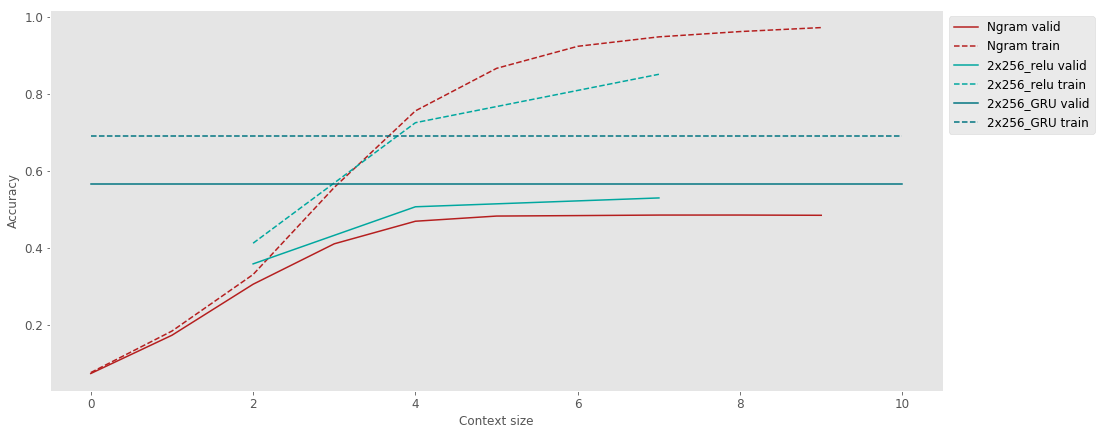

In [202]:
plt.figure(figsize=(16,7))
cidx = 0
for model_label, acc in accuracies.items():
    x = np.asarray([v[0] for v in acc['valid']])
    y = np.asarray([v[1] for v in acc['valid']])
    idxes = np.argsort(x)
    x = x[idxes]
    y = y[idxes]
    if len(x) > 1: 
        plt.plot(x,y,'-',label=model_label+' valid', c=c[cidx])
    else:
        plt.scatter(x[0],y[0],label=model_label+' valid', c=c[cidx])
        
    x = np.asarray([v[0] for v in acc['train']])
    y = np.asarray([v[1] for v in acc['train']])
    idxes = np.argsort(x)
    x = x[idxes]
    y = y[idxes]
    if len(x) > 1: 
        plt.plot(x,y,'--',label=model_label+' train', c=c[cidx])
    else:
        plt.scatter(x[0],y[0],marker='x',label=model_label+' train', c=c[cidx])
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.ylabel('Accuracy')
    plt.xlabel('Context size')
    cidx+=1





**Question**: Comment on the above plot. What do you conclude?

**Answer**:

## 4. (Optional) Generation

We provide you with some useful code, entertain yourself by using your trained models to generate new scores (conditioned on a rhythm). Use the plotPianoroll() function to visualize the results here and the writeMIDI() function to create a MIDI file from the note sequence.

In [ ]:
def sample(preds, temperature=.8):
    """
    Sample from a distribution with temperature
    """
    if temperature == 0.:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def sampleNmax(preds, Nmax=4, temperature=.8):
    """
    Sample from the N most probable entries
    """
    #return sample(preds)
    try:
        preds = np.asarray(preds)
        candidateidxes = np.argsort(preds)[-Nmax:]
        prcandidates = preds[candidateidxes]
        return candidateidxes[sample(prcandidates, temperature=temperature)]
    except:
        print(preds)
        print(candidateidxes)
        raise
        
def writeMIDI(score, path='../scores/', label="GeneratedScore", tag=None, resolution=256, bpm=100):

    # Instantiate a MIDI Pattern (contains a list of tracks)
    pattern = midi.Pattern(format = 0, resolution = resolution)
    # Instantiate a MIDI Track (contains a list of MIDI events)
    track = midi.Track()
    # Append the track to the pattern
    pattern.append(track)
    tick = 0
    Events = []

    #Set the tempo
    e = midi.SetTempoEvent()
    e.set_bpm(bpm)
    track.append(e)
    
    #Timing
    timeperbeat = 60. / bpm#[s]
    timepertick = timeperbeat/resolution
    longenough = False
    for dt, t, p in zip(score['dT'], score['T'], score['P']):
        if dt == 'START' or t == 'START' or p == 'START':
            continue
        if tick >= resolution*8:#more than 8 beats
            longenough = True
        if dt == 'END' or t == 'END' or p == 'END':
            break
        tick = tick + int(dt*resolution)
        Events.append({'t': tick, 'p': p, 'm': 'ON'})
        Events.append({'t': tick+int(t*resolution), 'p': p, 'm': 'OFF'})

    Events = sorted(Events, key=lambda k: k['t'])
    tick = 0
    for event in Events:
        if event['m'] == 'ON':
            if (event['t']-score['upbeat'])%score['beat_len'] < 1e-4:
                e =  midi.NoteOnEvent(tick=event['t']-tick, velocity=95, pitch=event['p'])
            else:
                e =  midi.NoteOnEvent(tick=event['t']-tick, velocity=90, pitch=event['p'])
        if event['m'] == 'OFF':
            e =  midi.NoteOffEvent(tick=event['t']-tick, velocity=90, pitch=event['p'])
        track.append(e)
        tick = event['t']
        

    # Add the end of track event, append it to the track
    eot = midi.EndOfTrackEvent(tick=1)
    track.append(eot)
    if longenough:
        # Save the pattern to disk
        if tag is None:
            midi.write_midifile(path+label+".mid", pattern)
        else:
            midi.write_midifile(path+label+"_"+tag+".mid", pattern)    
            print(label+"_"+tag+".mid")


In [ ]:
#Loading a model
model = load_model("../load/XXXXXmodel.save")
#Getting the output probabilities of a model given some data
model.predict({'XdT': XXX, 'XT': XXX, 'XP': XXX})